# SMS Spam Detection with Logistic Regression

## Import Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.utils import save_model, load_model

## Import Data

In [2]:
df = pd.read_csv("data/spam.csv")
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


Label 0 sms normal. <br>
Label 1 sms spam.

In [3]:
df.shape

(1143, 2)

Data terdiri dari 1143 baris dan 2 kolom.

In [4]:
df.dtypes

Teks     object
label     int64
dtype: object

Tipe data telah sesuai.

In [5]:
df.isna().sum()

Teks     0
label    0
dtype: int64

Data telah bersih.

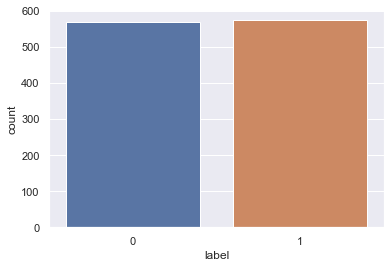

In [6]:
sns.countplot(df.label);

Target variabel balanced.

In [7]:
df.Teks[0]

'[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'

## Cleaning 

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sw_indo = stopwords.words('indonesian')

Idealnya kita definisikan sendiri stopwords kita tergantung masalah yang sedang dihadapi. Namun, kali ini saya hanya akan menggunakan stopwords indonesia bawaan nltk.

In [9]:
def cleansing(text):
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1]
    word_list = [word for word in word_list if word not in punctuation]
    word_list = [word for word in word_list if word not in sw_indo]
    text = ' '.join(word_list)
    return text

In [10]:
df['Teks'] = df.Teks.apply(cleansing)

In [11]:
df.head()

,Teks,label
0,PROMO Beli paket Flash 1GB MY TELKOMSEL APP dp...,1
1,2.5 GB/30 Rp 35 Ribu Spesial Anda terpilih Akt...,1
2,2016-07-08 11:47:11.Plg Yth sisa kuota Flash A...,1
3,2016-08-07 11:29:47.Plg Yth sisa kuota Flash A...,1
4,4.5GB/30 Rp 55 Ribu Spesial terpilih Aktifkan ...,1


In [12]:
df.Teks[0]

'PROMO Beli paket Flash 1GB MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE EXTRA nelpon 100mnt/1hr Buruan cek tsel.me/mytsel1'

## Dataset Splitting

In [13]:
X = df.Teks
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((914,), (229,), (914,), (229,))

## Modeling

In [14]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.linear_model import LogisticRegression

In [15]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(ngram_range=(1, 2))),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.logreg_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   14.6s finished


{'algo__C': 10.0, 'algo__fit_intercept': True}
1.0 0.969326325848065 0.982532751091703


## Evaluasi 

In [16]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix

In [17]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       455
           1       1.00      1.00      1.00       459

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914


Test report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       114
           1       0.97      1.00      0.98       115

    accuracy                           0.98       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.98      0.98      0.98       229



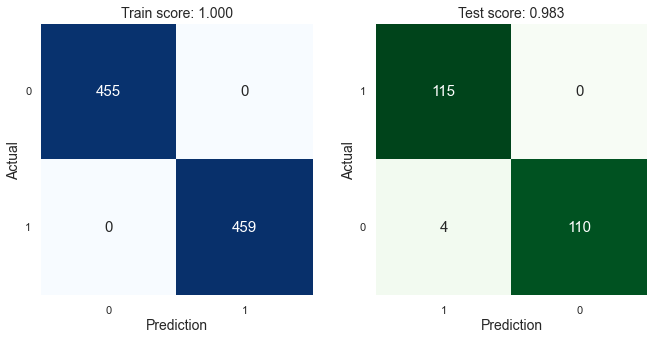

In [18]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## Check 

In [19]:
text = '''syng tolong belikan aqw pulsa di nomor ini 081256780987, nanti bakal aqw telpon syng'''
text = cleansing(text)
model.predict([text]), model.predict_proba([text])

(array([1], dtype=int64), array([[0.14026009, 0.85973991]]))

In [20]:
text = '''saya sedang dijalan untuk menuju rumah bapak'''
text = cleansing(text)
model.predict([text]), model.predict_proba([text])

(array([0], dtype=int64), array([[0.59884745, 0.40115255]]))

## Save Model

In [21]:
save_model(model.best_estimator_, "sms_spam.pkl")

Model is pickled as model/sms_spam.pkl
